In [1]:
import pandas as pd
df = pd.read_csv('scaled_combined_data.csv')
df.head()

,Unnamed: 0,accelerometer_right_foot_x,accelerometer_right_foot_y,accelerometer_right_foot_z,gyroscope_right_foot_x,gyroscope_right_foot_y,gyroscope_right_foot_z,accelerometer_right_shin_x,accelerometer_right_shin_y,accelerometer_right_shin_z,...,accelerometer_left_thigh_x,accelerometer_left_thigh_y,accelerometer_left_thigh_z,gyroscope_left_thigh_x,gyroscope_left_thigh_y,gyroscope_left_thigh_z,EMG_right,EMG_left,activity,source_file
0,-1.000000,-0.304677,-0.219226,0.311788,-0.000961,0.004623,-0.003372,-0.506218,0.034806,-0.074205,...,-0.493156,0.052384,-0.045884,0.016281,0.012436,0.003006,-0.015748,-0.094488,standing,HuGaDB_v2_various_16_09.csv
1,-0.999840,-0.304311,-0.222522,0.312032,-0.000656,0.004837,-0.004410,-0.503044,0.034073,-0.076890,...,-0.494377,0.055192,-0.039414,0.011429,0.009873,0.004257,-0.015748,-0.094488,standing,HuGaDB_v2_various_16_09.csv
2,-0.999679,-0.303700,-0.221302,0.312276,-0.001572,0.004654,-0.002884,-0.502678,0.037125,-0.074571,...,-0.496086,0.055070,-0.031968,0.012833,0.009903,0.006485,-0.015748,-0.094488,standing,HuGaDB_v2_various_16_09.csv
3,-0.999519,-0.304555,-0.220813,0.309957,-0.003037,0.006088,-0.004746,-0.501457,0.037369,-0.072496,...,-0.497307,0.052995,-0.027329,0.019577,0.003861,0.004471,-0.015748,-0.094488,standing,HuGaDB_v2_various_16_09.csv
4,-0.999359,-0.305531,-0.218616,0.311666,-0.002304,0.005997,-0.004227,-0.504509,0.032853,-0.076524,...,-0.498405,0.058854,-0.029892,0.023972,-0.001785,0.004440,-0.015748,-0.094488,standing,HuGaDB_v2_various_16_09.csv


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from collections import Counter

fs = 52                           # 采样率 (Hz)
window_seconds = [3]           # 窗口时长，可按需增删
overlap = 0.5                     # 重叠比例
channels = [c for c in df.columns if c not in ['activity', 'source_file', 'Unnamed: 0']]



In [3]:
def sliding_windows(data, win_len, step):
    """对单条序列做滑动窗口切分，返回 list of DataFrame 窗口"""
    windows = []
    for start in range(0, len(data) - win_len + 1, step):
        windows.append(data.iloc[start:start + win_len])
    return windows

def window_label(win):
    """多数投票确定窗口标签"""
    acts = win['activity'].values
    return Counter(acts).most_common(1)[0][0]

def segment_and_label(df_group, win_sec):
    """对一个 source_file 分组做切分并打标签"""
    win_len = int(win_sec * fs)
    step = int(win_len * (1 - overlap))
    wins = sliding_windows(df_group, win_len, step)
    X, y = [], []
    for w in wins:
        X.append(w[channels].values)              # 原始序列部分
        y.append(window_label(w))                 # 对应窗口标签
    return np.array(X), np.array(y)


In [4]:
all_X, all_y, all_meta = {}, {}, {}

for ws in window_seconds:
    X_list, y_list, meta_list = [], [], []
    for fname, grp in df.groupby('source_file'):
        Xw, yw = segment_and_label(grp, ws)
        X_list.append(Xw)
        y_list.append(yw)
        meta_list += [fname] * len(yw)
    all_X[ws] = np.vstack(X_list)
    all_y[ws] = np.concatenate(y_list)
    all_meta[ws] = meta_list

# 例如 2s 窗口：
print(f"{ws}s 窗口数量：", all_X[ws].shape, all_y[ws].shape)


3s 窗口数量： (14033, 156, 38) (14033,)


In [5]:
def extract_stat_features(X):
    """
    X 形状: [n_windows, win_len, n_channels]
    返回 DataFrame: [n_windows, 3*n_channels]
    """
    feats = []
    for win in X:
        mean_  = win.mean(axis=0)
        var_   = win.var(axis=0)
        kurt_  = kurtosis(win, axis=0)
        feats.append(np.concatenate([mean_, var_, kurt_]))
    # 构建列名
    cols = []
    for feat in ['mean', 'var', 'kurt']:
        cols += [f"{c}_{feat}" for c in channels]
    return pd.DataFrame(feats, columns=cols)

# 示例
stat_df_2s = extract_stat_features(all_X[ws])
stat_df_2s['label'] = all_y[ws]
stat_df_2s.head()


C:\Users\cyan1\AppData\Local\Temp\ipykernel_42764\2765112180.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_  = kurtosis(win, axis=0)


,accelerometer_right_foot_x_mean,accelerometer_right_foot_y_mean,accelerometer_right_foot_z_mean,gyroscope_right_foot_x_mean,gyroscope_right_foot_y_mean,gyroscope_right_foot_z_mean,accelerometer_right_shin_x_mean,accelerometer_right_shin_y_mean,accelerometer_right_shin_z_mean,gyroscope_right_shin_x_mean,...,gyroscope_left_shin_z_kurt,accelerometer_left_thigh_x_kurt,accelerometer_left_thigh_y_kurt,accelerometer_left_thigh_z_kurt,gyroscope_left_thigh_x_kurt,gyroscope_left_thigh_y_kurt,gyroscope_left_thigh_z_kurt,EMG_right_kurt,EMG_left_kurt,label
0,-0.240429,-0.040037,0.409229,-0.000375,0.000670,-0.000714,-0.452517,-0.005043,-0.208874,-0.000056,...,-0.309305,0.451985,-0.057063,-0.078483,-0.107058,0.655609,0.062610,-1.626354,0.302137,sitting
1,-0.240479,-0.040222,0.409056,-0.000403,0.000711,-0.000703,-0.452367,-0.005188,-0.209196,-0.000088,...,1.049770,0.168935,0.853974,0.076890,1.740462,0.169516,-0.138919,-1.239412,0.076775,sitting
2,-0.240294,-0.040730,0.408969,-0.000283,0.000235,-0.000621,-0.451431,-0.011571,-0.211797,0.000334,...,0.655550,2.755071,2.459712,6.185780,2.963796,0.746006,0.185701,9.244657,4.286765,sitting
3,-0.226379,-0.040661,0.416274,-0.000275,-0.000176,-0.000752,-0.463544,0.002033,-0.172168,-0.000149,...,0.385099,-1.607084,-1.262068,-1.711441,0.347782,-1.112874,-1.194849,4.828918,2.945135,standing_up
4,-0.210378,-0.040244,0.424651,-0.000427,0.000320,-0.000880,-0.478213,0.023018,-0.129984,-0.000568,...,0.258731,3.952159,1.387837,2.585558,1.770216,1.499729,-0.095457,3.558469,3.375417,standing


In [6]:
def extract_freq_features(X):
    """
    对每个窗口每个通道做 rFFT，计算谱能量
    返回 DataFrame: [n_windows, n_channels]
    """
    feats = []
    for win in X:
        energies = []
        for ch in range(win.shape[1]):
            # 计算单边频谱能量，除以长度归一化
            fft_vals = np.fft.rfft(win[:, ch])
            energy = np.sum(np.abs(fft_vals) ** 2) / len(fft_vals)
            energies.append(energy)
        feats.append(energies)
    cols = [f"{c}_fft_energy" for c in channels]
    return pd.DataFrame(feats, columns=cols)

# 示例
freq_df_2s = extract_freq_features(all_X[ws])
freq_df_2s['label'] = all_y[ws]
freq_df_2s.head()


,accelerometer_right_foot_x_fft_energy,accelerometer_right_foot_y_fft_energy,accelerometer_right_foot_z_fft_energy,gyroscope_right_foot_x_fft_energy,gyroscope_right_foot_y_fft_energy,gyroscope_right_foot_z_fft_energy,accelerometer_right_shin_x_fft_energy,accelerometer_right_shin_y_fft_energy,accelerometer_right_shin_z_fft_energy,gyroscope_right_shin_x_fft_energy,...,gyroscope_left_shin_z_fft_energy,accelerometer_left_thigh_x_fft_energy,accelerometer_left_thigh_y_fft_energy,accelerometer_left_thigh_z_fft_energy,gyroscope_left_thigh_x_fft_energy,gyroscope_left_thigh_y_fft_energy,gyroscope_left_thigh_z_fft_energy,EMG_right_fft_energy,EMG_left_fft_energy,label
0,17.807447,0.494023,51.589178,0.000048,0.000144,0.000158,63.081036,0.008662,13.441996,0.000004,...,0.000119,8.930584,1.336760,73.770577,0.000183,0.000003,0.000010,0.793575,0.005779,sitting
1,17.814922,0.498627,51.545704,0.000058,0.000167,0.000153,63.039249,0.009401,13.483819,0.000010,...,0.000102,8.917651,1.336185,73.908436,0.000163,0.000003,0.000024,0.776332,0.005694,sitting
2,17.795974,0.525338,51.526726,0.000172,0.000262,0.000186,62.781226,0.065378,13.853690,0.001959,...,0.000084,13.541336,1.174404,68.343626,0.000521,0.036303,0.000880,1.189393,0.562000,sitting
3,15.827971,0.530068,53.392538,0.000222,0.000257,0.000309,66.225603,0.094950,9.517123,0.003388,...,0.000094,43.699781,0.392617,26.648604,0.002003,0.079170,0.002437,1.320404,0.631551,standing_up
4,13.638689,0.506088,55.551875,0.000125,0.000105,0.000303,70.453859,0.180100,5.285877,0.001581,...,0.000062,75.182710,0.306013,0.906979,0.001832,0.029204,0.001316,0.910859,0.095577,standing


In [7]:
from sklearn.preprocessing import StandardScaler

# 原始切片形状: [n_windows, win_len, n_channels]
X_raw_2s = all_X[ws]

# 标准化后切片
n_wins, wlen, n_ch = X_raw_2s.shape
X_flat = X_raw_2s.reshape(-1, n_ch)          # [n_windows * win_len, n_channels]
scaler = StandardScaler().fit(X_flat)
X_std = scaler.transform(X_flat).reshape(n_wins, wlen, n_ch)

# 最终输入格式举例 （Keras/LSTM 一般用 [batch, time, feature]）
print("Raw shape:", X_raw_2s.shape)
print("Std shape:", X_std.shape)


Raw shape: (14033, 156, 38)
Std shape: (14033, 156, 38)


In [8]:
# 合并 2s 统计 + 频域 特征
features_2s = pd.concat([stat_df_2s.drop(columns='label'),
                         freq_df_2s.drop(columns='label')],
                        axis=1)
features_2s['label'] = stat_df_2s['label']  # 或 all_y[2]

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [10]:
X = X_std
y = all_y[ws]  # labels
X, y

(array([[[ 0.35539523,  0.45753101,  0.16372215, ..., -0.08427034,
          -0.26085821,  0.12950758],
         [ 0.34585413,  0.4516945 ,  0.17161368, ..., -0.08507496,
          -0.26085821,  0.08380382],
         [ 0.35279311,  0.45607188,  0.17439893, ..., -0.08427034,
          -0.26085821,  0.12950758],
         ...,
         [ 0.35452786,  0.46142202,  0.17347052, ..., -0.08789111,
          -0.26085821,  0.03810006],
         [ 0.35929841,  0.45461275,  0.16000849, ..., -0.08909804,
          -0.26085821,  0.03810006],
         [ 0.3562626 ,  0.45509913,  0.15490221, ..., -0.09030496,
          -0.26085821,  0.03810006]],
 
        [[ 0.35539523,  0.45655826,  0.15908008, ..., -0.08628188,
          -0.21255069, -0.0076037 ],
         [ 0.35582892,  0.46093564,  0.16140112, ..., -0.08869573,
          -0.21255069,  0.03810006],
         [ 0.34845625,  0.47017679,  0.16511478, ..., -0.08950035,
          -0.21255069,  0.03810006],
         ...,
         [ 0.35235942,  0.4541263

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # integers like 0,1,2,...


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11226, 156, 38), (2807, 156, 38), (11226,), (2807,))

In [13]:
n_steps= X.shape[1]
n_steps

156

In [18]:
from tensorflow.keras import layers, models
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
import keras_tuner
from tensorflow import keras


def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(n_steps, n_ch)))
    
    # Tune number of Conv1D layers (1-2)
    for i in range(hp.Int('conv_layers', 1, 2)):
        model.add(keras.layers.Conv1D(
            filters=hp.Int(f'filters_{i}', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice(f'kernel_size_{i}', [2,3,5]),
            activation='relu',
            padding='same'
        ))
        model.add(keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
        hp.Int('dense_units', 32, 128, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [19]:
tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=20,
    directory='my_dir',
    project_name='activity_classification_v10'  # different project name
)


In [20]:
tuner.search(X_train, y_train,
             epochs=20,
             batch_size=64,
             validation_split=0.2,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])
best_model = tuner.get_best_models()[0]


Trial 20 Complete [00h 00m 19s]
accuracy: 0.8493906855583191

Best accuracy So Far: 0.8594821095466614
Total elapsed time: 00h 03m 56s


In [21]:
# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print("Best hyperparameters found:")
for key, value in best_hp.values.items():
    print(f"{key}: {value}")

Best hyperparameters found:
conv_layers: 2
filters_0: 16
kernel_size_0: 3
dense_units: 96
dropout: 0.1
learning_rate: 0.002998003302664412
filters_1: 48
kernel_size_1: 5


In [14]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_ch)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.00034), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 154, 128)          14720     
                                                                 
 batch_normalization (BatchN  (None, 154, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 77, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 77, 128)           0         
                                                                 
 flatten (Flatten)           (None, 9856)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [15]:
history = model.fit(X_train, y_train, epochs=250, verbose=1, batch_size=64)

Epoch 1/250
176/176 [==============================] - 12s 11ms/step - loss: 1.2579 - accuracy: 0.6221
Epoch 2/250
176/176 [==============================] - 2s 9ms/step - loss: 0.6274 - accuracy: 0.7637
Epoch 3/250
176/176 [==============================] - 2s 9ms/step - loss: 0.5233 - accuracy: 0.7874
Epoch 4/250
176/176 [==============================] - 2s 9ms/step - loss: 0.4548 - accuracy: 0.8070
Epoch 5/250
176/176 [==============================] - 2s 9ms/step - loss: 0.4299 - accuracy: 0.8103
Epoch 6/250
176/176 [==============================] - 2s 9ms/step - loss: 0.4046 - accuracy: 0.8205
Epoch 7/250
176/176 [==============================] - 2s 9ms/step - loss: 0.3769 - accuracy: 0.8279
Epoch 8/250
176/176 [==============================] - 2s 9ms/step - loss: 0.3560 - accuracy: 0.8308
Epoch 9/250
176/176 [==============================] - 2s 9ms/step - loss: 0.3532 - accuracy: 0.8341
Epoch 10/250
176/176 [==============================] - 2s 9ms/step - loss: 0.3476 - accu

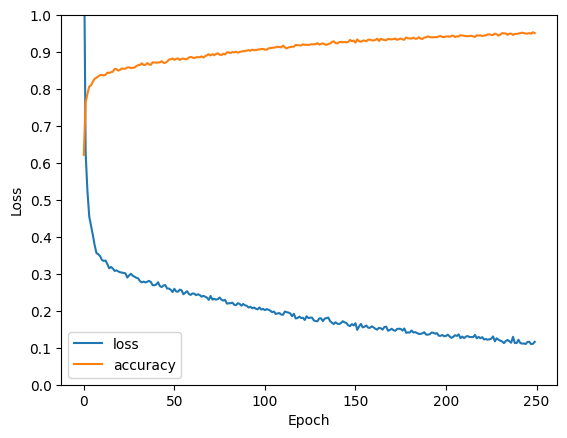

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.ylim(0,1)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()


In [18]:
y_probs = model.predict(X_test)          # shape: (num_samples, 10)

88/88 [==============================] - 1s 4ms/step


In [19]:
import numpy as np
y_pred = np.argmax(y_probs, axis=1)      # shape: (num_samples,)

In [20]:
N_SAMPLES_TO_SHOW = 10

# Convert one-hot y_test if needed
y_true = y_test
if y_test.ndim == 2:
    y_true = np.argmax(y_test, axis=1)

y_pred = np.argmax(y_probs, axis=1)
conf = y_probs[np.arange(len(y_probs)), y_pred]

df_compare = pd.DataFrame({
    "index": np.arange(len(y_true)),
    "y_true": y_true,
    "y_pred": y_pred,
    "confidence": conf
})

df_compare.sample(N_SAMPLES_TO_SHOW)

,index,y_true,y_pred,confidence
2308,2308,2,2,1.000000
1775,1775,9,9,1.000000
413,413,2,2,1.000000
2540,2540,8,8,0.513583
2175,2175,9,9,1.000000
1582,1582,3,3,1.000000
2288,2288,9,1,0.940793
221,221,9,9,1.000000
688,688,9,9,1.000000
2618,2618,2,2,1.000000


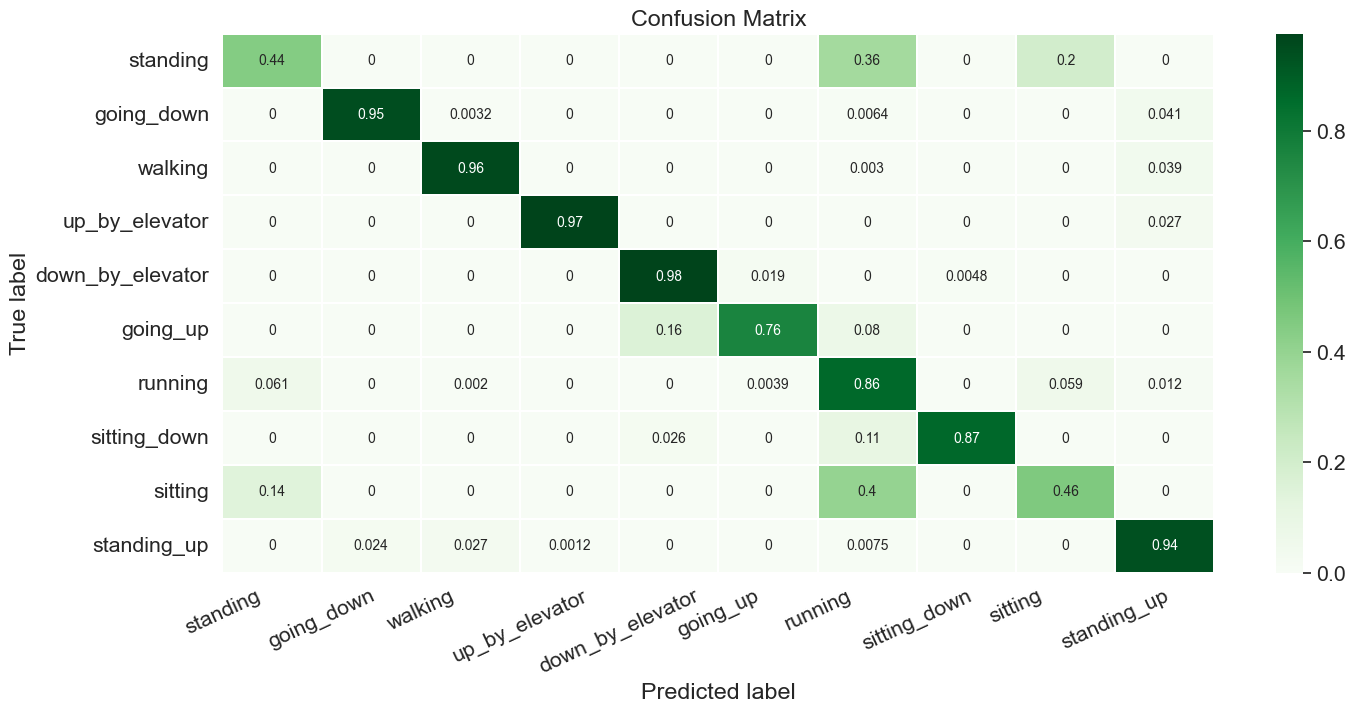

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['standing', 'going_down', 'walking', 'up_by_elevator', 'down_by_elevator', 'going_up', 'running', 'sitting_down', 'sitting', 'standing_up']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()